In [3]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import os
import glob
from scipy import io

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")

# Plotting preferences

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
myFmt = md.DateFormatter('%H/%d')
rule = md.HourLocator(interval=12)

In [4]:
# Function to get just the last lines of a file

def tail( f, lines=20 ):
    total_lines_wanted = lines
    BLOCK_SIZE = 1024
    f.seek(0, 2)
    block_end_byte = f.tell()
    lines_to_go = total_lines_wanted
    block_number = -1
    blocks = [] # blocks of size BLOCK_SIZE, in reverse order starting
                # from the end of the file
    while lines_to_go > 0 and block_end_byte > 0:
        if (block_end_byte - BLOCK_SIZE > 0):
            # read the last block we haven't yet read
            f.seek(block_number*BLOCK_SIZE, 2)
            blocks.append(f.read(BLOCK_SIZE))
        else:
            # file too small, start from begining
            f.seek(0,0)
            # only read what was not read
            blocks.append(f.read(block_end_byte))
        lines_found = blocks[-1].count(b'\n')
        lines_to_go -= lines_found
        block_end_byte -= BLOCK_SIZE
        block_number -= 1
    all_read_text = b''.join(reversed(blocks))
    all_read_text = all_read_text.decode("utf-8")
    return '\n'.join(all_read_text.splitlines()[-total_lines_wanted:])

def get_opc(opc_n,d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*OPC*'%opc_n)
    if opc_n=='TAWO':
        file_dates = np.asarray([(dt.datetime.strptime(f[-12:-4], '%Y%m%d')).date() for f in all_files])
    else:
        file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
           
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    opc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        opc = opc.append(pd.read_csv(f, skiprows=4,sep=',',error_bad_lines=False))  
    opc['Dates'] = pd.to_datetime(opc['time'],format='%Y-%m-%d %H:%M:%S')
    opc = opc.sort_values('Dates')
    opc = opc.set_index(opc['Dates'])
    opc.index = pd.DatetimeIndex(opc.index)
    #opc = opc[~opc.index.duplicated()]
    del opc['time'], opc['Dates']

    # Convert flow rate from L/min to cm3/s
    # 1 L/min = 16.66667 cm3/s
    opc.FlowRate = opc.FlowRate/100 * 16.66667

    # Get total counts
    opc['total_counts']=opc['b0'].astype(float)+ opc['b1'].astype(float)+ opc['b2'].astype(float)+ opc['b3'].astype(float)+ opc['b4'].astype(float)+ opc['b5'].astype(float)+ opc['b6'].astype(float)+ opc['b7'].astype(float)+ opc['b8'].astype(float)+ opc['b9'].astype(float)+ opc['b10'].astype(float)+ opc['b11'].astype(float)+ opc['b12'].astype(float)+ opc['b13'].astype(float)+ opc['b14'].astype(float)+ opc['b15'].astype(float)+ opc['b16'].astype(float)+ opc['b17'].astype(float)+ opc['b18'].astype(float)+ opc['b19'].astype(float)+ opc['b20'].astype(float)+ opc['b21'].astype(float)+ opc['b22'].astype(float)+ opc['b23'].astype(float)
    opc['total_counts']=opc['total_counts'].replace({0: np.nan})
    # Convert total counts/interval to total counts/s
    opc.period = opc.period/100 # period in s
    opc.total_counts = opc.total_counts /opc.period
    # Convert total counts/second to counts/cm3
    opc['OPC_conc'] = opc.total_counts / opc.FlowRate

    return opc

# Function to read SKYOPC data
# Get SKYOPC Data
# Measurement interval 6 seconds
# I think C0 = time
# C1 = time + 6 s
# C2 = time + 12 s
# ect.

# 32 channels 
# data output in the unit particle/100ml

# SKYOPC chaneel boundaries:
#0.25,0.28,0.3,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.0,1.3,1.6,2,2.5,3,3.5,4,5,6.5,7.5,8.5,10,12.5,15,17.5,20,25,30,32 
#channels 16 and 17 are identical (overlapping 
#channel for different physical measurement ranges)...so one should be 
#discarded before analysis.

# Function to read and import GRIMM OPC data
def get_skyopc(d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*SKYOPC*')
    file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    skyopc = pd.DataFrame()
    c=np.nan
    # Extract the data
    for f in dfs: 
        # Ignore file if it's empty
        if os.path.getsize(f)==0:
            #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        f_data = open(f)
        d = f_data.readlines()
        f_data.close()
        for i in range(0,len(d)):
            line=d[i].split()
            if line[0] =='P':
                if len(line)!=17:
                    c=0
                    datetime=np.nan
                    continue
                #Year Mon Day Hr Min Loc 4Tmp Err pA/p pR/p UeL Ue4 Ue3 Ue2 Ue1 Iv 
                datetime = dt.datetime(int(line[1])+2000,int(line[2]),int(line[3]),int(line[4]),int(line[5]))
                #datetime = dt.datetime.strptime('20'+line[1]+line[2]+line[3]+line[4]+line[5],'%Y%m%d%H%M')
                quad_Tmp = int(line[7])
                Err = int(line[8])
                pAp = int(line[9])
                pRp = int(line[10])
                Int = int(line[16])
                c=0
            
            elif len(line)!=9:
                continue

            elif c==0: 
                ch1=int(line[1])
                ch2=int(line[2])
                ch3=int(line[3])
                ch4=int(line[4])
                ch5=int(line[5])
                ch6=int(line[6])
                ch7=int(line[7])
                ch8=int(line[8])
                c = c+1    
            elif c ==1:
                ch9=int(line[1])
                ch10=int(line[2])
                ch11=int(line[3])
                ch12=int(line[4])
                ch13=int(line[5])
                ch14=int(line[6])
                ch15=int(line[7])
                ch16=int(line[8])
                c = c+1
            elif c == 2:
                ch17=int(line[1])
                ch18=int(line[2])
                ch19=int(line[3])
                ch20=int(line[4])
                ch21=int(line[5])
                ch22=int(line[6])
                ch23=int(line[7])
                ch24 =int(line[8])
                c= c+1
            elif c==3:
                ch25=int(line[1])
                ch26=int(line[2])
                ch27=int(line[3])
                ch28=int(line[4])
                ch29=int(line[5])
                ch30=int(line[6])
                ch31=int(line[7])
                ch32=int(line[8])
                c = 0
                n = int(line[0][-2])
                if isinstance(datetime,dt.datetime):
                    skyopc = skyopc.append(pd.Series([datetime+dt.timedelta(seconds=n*6), ch1, ch2, ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12, ch13, ch14, ch15, ch16, ch17, ch18, ch19, ch20, ch21, ch22, ch23, ch24, ch25, ch26, ch27, ch28, ch29, ch30, ch31, ch32, quad_Tmp,Err,pAp,pRp,Int]),ignore_index=True)
            
    # remove repeated channel 16
    del skyopc[16]
    # Correct counts for size bins 'all counts above lower threshold.'        
    for i in range(2,16):
        skyopc[i-1]=skyopc[i-1]-skyopc[i]
    for i in range(18,33):
        skyopc[i-1]=skyopc[i-1]-skyopc[i]
    
    skyopc=skyopc.rename(columns={0: 'Date',1:'ch1' ,2: 'ch2', 3: 'ch3',4: 'ch4',5: 'ch5',6: 'ch6',7: 'ch7',8: 'ch8',9: 'ch9',10: 'ch10',11: 'ch11',12: 'ch12',13: 'ch13',14: 'ch14',15: 'ch15',16: 'ch16',17: 'ch17',18: 'ch18',19: 'ch19', 20:'ch20',21: 'ch21',22: 'ch22',23: 'ch23',24: 'ch24',25: 'ch25',26: 'ch26',27: 'ch27',28: 'ch28',29: 'ch29',30: 'ch30',31: 'ch31',32: 'ch32',33: 'quad_Tmp',34:'Err',35:'pAp',36:'pRp',37:'Int'})
    skyopc.dropna(inplace=True)
    skyopc = skyopc.set_index('Date')
    skyopc = skyopc.sort_values('Date')
    skyopc.index = pd.DatetimeIndex(skyopc.index)
    skyopc = skyopc[~skyopc.index.duplicated()]

    # Units: counts/100ml == 100 counts/cm3
    # Calculate total counts/cm3 by adding bins
    skyopc['SKYOPC_conc']=skyopc['ch1']+skyopc['ch2']+skyopc['ch3']+skyopc['ch4']+skyopc['ch5']+skyopc['ch6']+skyopc['ch7']+skyopc['ch8']+skyopc['ch9']+skyopc['ch10']+skyopc['ch11']+skyopc['ch12']+skyopc['ch13']+skyopc['ch14']+skyopc['ch15']+skyopc['ch17']+skyopc['ch18']+skyopc['ch19']+skyopc['ch20']+skyopc['ch21']+skyopc['ch22']+skyopc['ch23']+skyopc['ch24']+skyopc['ch25']+skyopc['ch26']+skyopc['ch27']+skyopc['ch28']+skyopc['ch29']+skyopc['ch30']+skyopc['ch31']+skyopc['ch32']
    skyopc['SKYOPC_conc']=skyopc['SKYOPC_conc']/100 #counts/cm3
    skyopc['SKYOPC_conc']=skyopc['SKYOPC_conc'].astype(float)
    
    return skyopc

# Function to read CPC data

def get_cpc(d_loc,d1,d2):
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*CPC*')
    file_dates = np.asarray([(dt.datetime.strptime(f[11:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    cpc = pd.DataFrame()
    # Extract the data
    for f in dfs: 
    # Ignore file if it's empty
        if os.path.getsize(f)==0:
        #log.write('Error with: '+f+' this file is empty.\n')
            continue 
        cpc = cpc.append(pd.read_csv(f, header=None, sep=',',error_bad_lines=False))    

    cpc[0]= pd.to_numeric(cpc[0],errors='coerce')
    cpc[1]= pd.to_numeric(cpc[1],errors='coerce')
    cpc[2]= pd.to_numeric(cpc[2],errors='coerce')
    cpc[3]= pd.to_numeric(cpc[3],errors='coerce')
    cpc[4]= pd.to_numeric(cpc[4],errors='coerce')
    cpc[5]= pd.to_numeric(cpc[5],errors='coerce')
    cpc.dropna(inplace=True)
    cpc[5]=cpc[5].astype(int)
    cpc=cpc.rename(columns={0: "year", 1: "month", 2: "day", 3: "hour", 4: "minute", 5: "second"})
    cpc['Date'] = pd.to_datetime(cpc[['year', 'month', 'day', 'hour', 'minute','second']])
    cpc = cpc.set_index('Date')
    cpc['CPC_conc']=cpc[6] # Counts per cubic cm
    del cpc[6]
    cpc = cpc.sort_values('Date')
    cpc.index = pd.DatetimeIndex(cpc.index)
    #cpc = cpc[~cpc.index.duplicated()]
    cpc['CPC_conc']=cpc['CPC_conc'].astype(float) 
    
    return cpc

# Function to read and process CLASP data
# Inputs

def get_clasp(d_loc,d1,d2,claspn,channels,calfile,sf):
    # Function to convery interger to binary.
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    os.chdir(d_loc+'Data/')                  # Change directory to where the data is
    #log = open(log_licor,'w')             # Open the log file for writing
    all_files = glob.glob('*%s*'%claspn)
    file_dates = np.asarray([(dt.datetime.strptime(f[-14:-4], '%Y-%m-%d')).date() for f in all_files])
    idxs = np.where(np.logical_and(file_dates>=d1.date(), file_dates<=d2.date()))[0]
    dfs = [all_files[i] for i in idxs]
    data_block=[]
    for f in dfs: 
        # Read in the data
        fid = open(f)
        data_block.append(list(filter(('\n').__ne__, fid.readlines())))
        fid.close()
        
    data_block=list(np.concatenate(data_block))
     
    # Initialise empty dataframes
    dates = []
    CLASP = np.ones([np.shape(data_block)[0],16])*-999  # Counts
    statusaddr = np.ones(np.shape(data_block)[0])*-999  # Status address
    parameter = np.ones(np.shape(data_block)[0])*-999   # Parameter value
    overflow = np.ones(np.shape(data_block)[0])*-999    # Overflow (channel 1-8 only)
    #flow_check = np.ones(len(data_block))*-999  # True if flow is in range - this is too stringent, can ignore
    heater = np.ones(np.shape(data_block)[0])*-999      # True if heater is on
    #sync = np.ones(len(data_block))*-999       # CAN IGNORE THIS - it's not connected

    # Loop through, extract and sort data into the dataframes initialised above
    for i in range(0,np.shape(data_block)[0]):
        split = data_block[i].split()
        # Extract and store dates
        date = dt.datetime(int(split[0]),int(split[1]),int(split[2]),
                           int(split[3]),int(split[4]),
                           int(np.floor(float(split[5])))) 
        dates.append(date)   

        if len(split)!=25:
            continue
    
        # Extract and store counts
        for x in range(0,16):
            CLASP[i,x] = float(split[-16:][x])    
    
        # Extract, and convert staus addresses, store flags
        statusbyte=float(split[6])
        binary=get_bin(int(statusbyte),8)
        statusaddr[i] = int(binary[4:8],2)
        heater[i] = int(binary[2])       # check you have these the right way around
         
        # Extract and store status parameters and overflow flag
        parameter[i]=float(split[7])
        overflow[i]=float(split[8])  
      
        # Check overflow flags and correct histogram. 
        # Overflow is for channels 1 to 8 only.
        for n in range(0,8):
            obin=get_bin(int(overflow[i]),8)
            if int(obin[::-1][0]):
                #print('overfow recorded')
                CLASP[i,n] = CLASP[i,n] + 256
                
        # Arrange parameters into a neat dataframe
    param_len = int(len(statusaddr)/10)
    param_dates = np.asarray(dates)[np.where(statusaddr==0)[0][0:param_len]]
    if len(param_dates)<param_len:
        param_len = len(param_dates)
    
    rejects = parameter[np.where(statusaddr==0)[0][0:param_len]]
    threshold = parameter[np.where(statusaddr==1)[0][0:param_len]]
    ThisFlow = parameter[np.where(statusaddr==2)[0][0:param_len]]
    FlowPWM = parameter[np.where(statusaddr==3)[0][0:param_len]]
    PumpCurrent = parameter[np.where(statusaddr==4)[0][0:param_len]]
    SensorT = parameter[np.where(statusaddr==5)[0][0:param_len]]
    HousingT = parameter[np.where(statusaddr==6)[0][0:param_len]]
    PumpT = parameter[np.where(statusaddr==7)[0][0:param_len]]
    SupplyV = parameter[np.where(statusaddr==8)[0][0:param_len]]
    LaserR  = parameter[np.where(statusaddr==9)[0][0:param_len]]

    param_df=pd.DataFrame({'Date':param_dates,'Rejects (n)':rejects,'Threshold (mV)':threshold,
                        'ThisFlow':ThisFlow,'FlowPWM':FlowPWM,'PumpCurrent (mA)':PumpCurrent,
                        'SensorT (C)':SensorT,'HousingT (C)':HousingT,'PumpT (C)':PumpT,
                        'SupplyV':SupplyV,'LaserR':LaserR})

    param_df = param_df.set_index('Date')
    param_df.index = pd.DatetimeIndex(param_df.index)
    param_df = param_df[~param_df.index.duplicated()]

    # Arrange Counts into a neat dataframe
    CLASP_df = pd.DataFrame({'Date':dates, 'Heater flag':heater,
                        1:CLASP[:,0],2:CLASP[:,1],
                        3:CLASP[:,2],4:CLASP[:,3], 5:CLASP[:,4],
                        6:CLASP[:,5],7:CLASP[:,6],8:CLASP[:,7],9:CLASP[:,8],
                        10:CLASP[:,9],11:CLASP[:,10],12:CLASP[:,11], 
                        13:CLASP[:,12],14:CLASP[:,13],15:CLASP[:,14],16:CLASP[:,15]})
    CLASP_df = CLASP_df.set_index('Date')
    CLASP_df.index = pd.DatetimeIndex(CLASP_df.index)
    CLASP_df = CLASP_df[~CLASP_df.index.duplicated()]
    CLASP_df = pd.concat([CLASP_df, param_df], axis=1)

    # Apply flow corrections and quality flags, 
    # convert raw counts to concentrations in particles per ml.
    # Get calibration data
    cal_dict=io.loadmat(calfile,matlab_compatible=True)
    TSIflow = cal_dict['calibr'][0][0][8][0]         # array of calibration flow rates from TSI flow meter
    realflow = cal_dict['calibr'][0][0][9][0]        # array of measured A2D flow rates matching TSflow

    # Do flow correction and convert to concentations
    # TSI flow is from the TSI flowmeter, realflow is the flow the CLASP records internally
    P = np.polyfit(realflow,TSIflow,2) # These are from the flow calibration - fit a polynomial
    flow = np.polyval(P,CLASP_df['ThisFlow']) # flow in L/min
    flow_correction = ((flow/60)*1000)/sf # Sample volume in ml/s

    # Interpolate flow correction onto full timeseries and add to array
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    nans, x= nan_helper(flow_correction)
    flow_correction[nans]= np.interp(x(nans), x(~nans), flow_correction[~nans])
    CLASP_df['Sample volume (ml/s)']=flow_correction

    # Now to plot concentrations in counts/ml, just need to divide the counts/s by the sample volume
    CLASP_df['total_counts']=CLASP_df[1].astype(float)+ CLASP_df[2].astype(float)+CLASP_df[3].astype(float)+CLASP_df[4].astype(float)+CLASP_df[5].astype(float)+CLASP_df[6].astype(float)+CLASP_df[7].astype(float)+CLASP_df[8].astype(float)+CLASP_df[9].astype(float)+CLASP_df[10].astype(float)+CLASP_df[11].astype(float)+CLASP_df[12].astype(float)+CLASP_df[13].astype(float)+CLASP_df[14].astype(float)+CLASP_df[15].astype(float)+CLASP_df[16].astype(float)
    # CLASP-G flowrate = 3L/minute = 50 cm3/second
    # Units: particle counts/ sample interval
    # Sample interval: 1s
    # Calculate total counts
    # Calculate concentation
    
    CLASP_df['CLASP_conc'] = CLASP_df['total_counts'] / 50 #counts/cm3
    
    return CLASP_df


In [5]:
d_loc='/Users/heather/ICECAPS-ACE/temp_data/home/fluxtower/'
# Get plot times
d1 = dt.datetime(2019,8,12)
d2 = dt.datetime(2019,8,13)

MSF_OPC = get_opc('MSF',d_loc,d1,d2)
SKYOPC = get_skyopc(d_loc,d1,d2)
CPC = get_cpc(d_loc,d1,d2)

channels = 16 # Number of aerosol concentration channels (usually 16)
calfile = '/Users/heather/Desktop/Summit_May_2019/Instruments/CLASP/CLASP-cal-Feb2019/calibration-unit-F-Feb2019.mat' # Calibration .mat file
CLASP = get_clasp(d_loc,d1,d2,'CLASP_F',16,calfile,1)

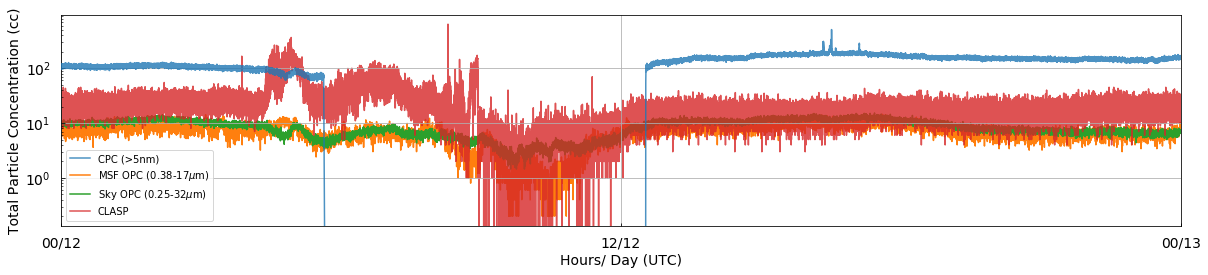

In [8]:


# Plot & save 
fig = plt.figure(figsize=(17,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(CPC.index,CPC.CPC_conc, label='CPC (>5nm)',zorder=3,alpha=0.8)
ax.semilogy(MSF_OPC.index,MSF_OPC.total_counts,label = 'MSF OPC (0.38-17$\mu$m)',zorder=1)  
ax.semilogy(SKYOPC.index,SKYOPC.SKYOPC_conc,label = 'Sky OPC (0.25-32$\mu$m)',zorder=1)
ax.semilogy(CLASP.index,CLASP.total_counts,label = 'CLASP',zorder=1,alpha=0.8)

#ax.set_ylim(0,yulim)
ax.set_ylabel('Total Particle Concentration (cc)')
#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.set_xlabel('Hours/ Day (UTC)')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(rule)
ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')


In [11]:
# QC SKYOPC params
# quad_Tmp Err pAp pRp Int

# quad_tmp : Temperature inside the device deg C
# err: error codes
# pap: Pressure after critical orifice aerosol / pressure in front of critical orifice *255 
#      (Must be smaller than 120) 
# prp = Pressure after critical orifice rinsing air / pressure in front of critical orifice *255 
#      (Must be smaller than 120)
# Int = interval in seconds. 

def QC_SKYOPC(skyopc):
# Check pap and prp <120 else nan. 
    skyopc[skyopc['pRp'] > 120] = np.nan
    skyopc[skyopc['pAp'] > 120] = np.nan
# Check int 6s else nan
    skyopc[skyopc['Int'] != 6 ] = np.nan
# Check err = 0 else nan
    skyopc[skyopc['Err'] != 0] = np.nan
    
    return skyopc

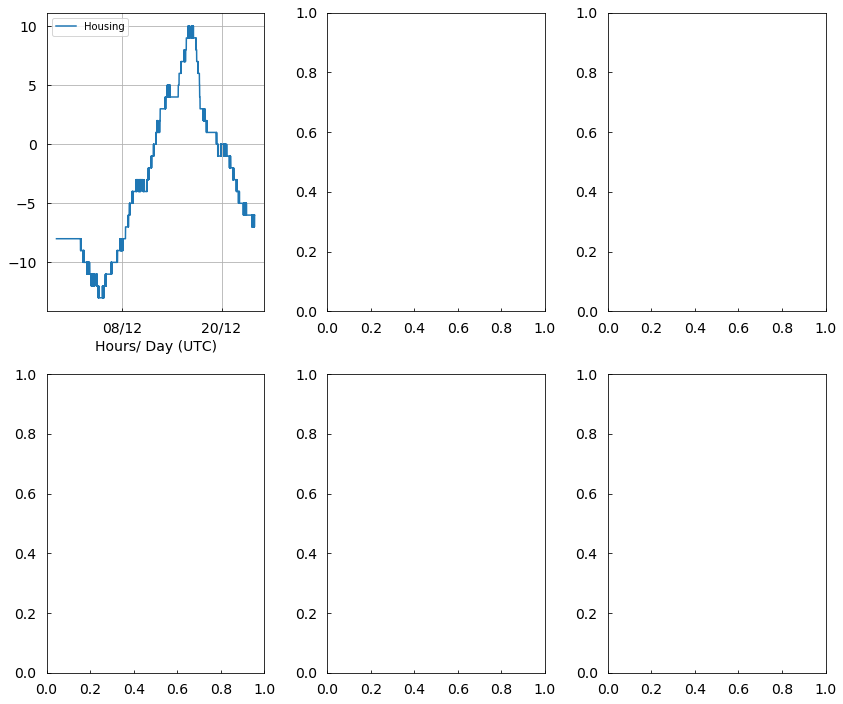

In [33]:
# Plot CLASP params
# HousingT, PumpT, SensorT
# LaserR
# ThisFlow
# Sample volume (ml/s)
# ThisFlow
# Rejects (n)
def dropnans(df,col):
    plot_data = df[col].dropna()
    return plot_data

# Plot & save 
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(231)
HT=dropnans(CLASP,'HousingT (C)')
ax1.plot(HT.index,HT,label='Housing')
#ax1.plot(CLASP.index,CLASP['SensorT (C)'].dropna(),label='Sensor')
#ax1.plot(CLASP.index,CLASP['PumpT (C)'].dropna(),label='Pump')

ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.grid(True)

#ax.set_ylim(0,yulim)
#ax1.set_ylabel('Total Particle Concentration (cc)')
#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax1.set_xlabel('Hours/ Day (UTC)')
ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)
#ax1.set_xlim(d1,d2)
ax1.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')

In [32]:
HT

Date
2019-08-12 00:00:18   -8.0
2019-08-12 00:00:28   -8.0
2019-08-12 00:00:38   -8.0
2019-08-12 00:00:48   -8.0
2019-08-12 00:00:58   -8.0
2019-08-12 00:01:08   -8.0
2019-08-12 00:01:18   -8.0
2019-08-12 00:01:28   -8.0
2019-08-12 00:01:38   -8.0
2019-08-12 00:01:48   -8.0
2019-08-12 00:01:58   -8.0
2019-08-12 00:02:08   -8.0
2019-08-12 00:02:18   -8.0
2019-08-12 00:02:28   -8.0
2019-08-12 00:02:38   -8.0
2019-08-12 00:02:48   -8.0
2019-08-12 00:02:58   -8.0
2019-08-12 00:03:08   -8.0
2019-08-12 00:03:18   -8.0
2019-08-12 00:03:28   -8.0
2019-08-12 00:03:38   -8.0
2019-08-12 00:03:48   -8.0
2019-08-12 00:03:58   -8.0
2019-08-12 00:04:08   -8.0
2019-08-12 00:04:18   -8.0
2019-08-12 00:04:28   -8.0
2019-08-12 00:04:38   -8.0
2019-08-12 00:04:48   -8.0
2019-08-12 00:04:58   -8.0
2019-08-12 00:05:08   -8.0
                      ... 
2019-08-12 23:55:06   -6.0
2019-08-12 23:55:16   -6.0
2019-08-12 23:55:26   -6.0
2019-08-12 23:55:36   -6.0
2019-08-12 23:55:46   -6.0
2019-08-12 23:55:56   -